In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import numpy as np
from tqdm import tqdm

# utility functions
from functions import get_cols_inf, get_nan_columns, get_cols_zerostd, plot_actual_vs_pred
from evaluate import evaluate_model

# Functions

## Preprocessing / Feature Engineering

In [2]:
def preprocess_train(train, columns_to_drop=[]):
    df = train.copy()
    
    #### Preprocessing
    # Identify once at the start
    cols_inf = get_cols_inf(df)
    print("Columns with infinite values:", cols_inf)
    cols_nan = get_nan_columns(df)
    print("Columns with NaN values:", cols_nan)
    cols_zerostd = get_cols_zerostd(df)
    print("Columns with zero standard deviation:", cols_zerostd)
    # Drop all at once
    cols_to_drop = set(cols_inf) | set(cols_nan) | set(cols_zerostd)

    df = df.drop(columns=cols_to_drop)

    #### Feature Engineering

    df.loc[:, 'bidask_ratio'] = df['bid_qty'] / df['ask_qty']
    df.loc[:, 'buysell_ratio'] = np.where(df['volume'] == 0, 0, df['buy_qty'] / df['sell_qty'])
    df.loc[:, 'liqnorm_buysellratio'] = np.where(df['volume'] == 0, 0, (df['buy_qty'] + df['sell_qty']) / df['volume'] )
    df.loc[:, 'orderflow_imbalance'] = np.where(df['volume'] == 0, 0, (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty']))

    # df.loc[:, 'buysell_ratio_shift1'] = df['buysell_ratio'].shift(-1)

    df.loc[:, 'bidask_delta'] = df['bid_qty'] - df['ask_qty']
    df.loc[:, 'buysell_delta'] = df['buy_qty'] - df['sell_qty']

    df.loc[:, 'buysell_size'] = df['buy_qty'] + df['sell_qty']
    df.loc[:, 'bidask_size'] = df['bid_qty'] + df['ask_qty']


    # Final Drop
    df = df.drop(columns=columns_to_drop)
    df = df.sort_index(ascending=True)
    return df

## Data Splitting

1. `sklearn_timeseries_split` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html))
   1. expanding window, rolling forward
2. `sklearn_traintest_split`
   1. fixed window
3. `walkforward_split`
   1. fixed window, rolling forward

In [3]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split


def sklearn_timeseries_split(X, n_splits=5, **kwargs):
    tscv = TimeSeriesSplit(n_splits=n_splits, **kwargs)
    for train_idx, test_idx in tscv.split(X):
        yield train_idx, test_idx

def sklearn_traintest_split(X, y, test_size=0.2, **kwargs):
    return train_test_split(X, y, test_size=test_size, **kwargs)

def walkforward_split(X, initial_train_size, test_size, step_size=1):
    """
    Generator for walk-forward validation splits.

    Parameters:
    - X: pandas DataFrame or Series (indexed by time)
    - initial_train_size: int, number of initial observations for training
    - test_size: int, number of observations in each test fold
    - step_size: int, how much the train/test window shifts per iteration

    Yields:
    - (train_index, test_index): tuple of numpy arrays
    """
    n = len(X)
    train_start = 0

    for train_end in range(initial_train_size, n - test_size + 1, step_size):
        test_start = train_end
        test_end = test_start + test_size

        train_index = np.arange(train_start, train_end)
        test_index = np.arange(test_start, test_end)

        yield train_index, test_index

## Models

In [4]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

def model_tree_randomforest(X, y, n_estimators=100, max_features='auto', **kwargs):
    """Random Forest: bagging + random feature subsets for decorrelation"""
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        **kwargs
    )
    model.fit(X, y)
    return model

def model_tree_adaboost(X, y, n_estimators=50, learning_rate=1.0, base_estimator=None, **kwargs):
    """AdaBoost Regression: sequential stumps fitted to weighted residuals"""
    base = base_estimator or DecisionTreeRegressor(max_depth=1)
    model = AdaBoostRegressor(
        base_estimator=base,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        **kwargs
    )
    model.fit(X, y)
    return model

def model_tree_xgboost(X, y, n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1, reg_alpha=0, **kwargs):
    """XGBoost: GBM with regularized leaf weights and efficient split finding"""
    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        **kwargs
    )
    model.fit(X, y)
    return model


def model_tree_lightgbm(X, y, n_estimators=100, learning_rate=0.1, num_leaves=31, **kwargs):
    """LightGBM: leaf-wise growth with histogram binning for speed"""
    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        **kwargs
    )
    model.fit(X, y)
    return model

## Optimization

In [5]:
def evaluate_grid(X, y, params_data, params_split, params_model, is_linear=False, metric_func=evaluate_model):
    all_results = []

    # Calculate total iterations for tqdm progress bar
    total_iters = len(params_data) * len(params_split) * len(params_model)

    with tqdm(total=total_iters, desc="Total Model Runs") as pbar:
        for data_key, data_val in params_data.items():
            mask = (X.index >= data_val['start']) & (X.index <= data_val['end'])
            X_window = X.loc[mask]
            y_window = y.loc[mask]

            for split_key, split_val in params_split.items():
                splitter_func = split_val['splitter_func']
                splitter_args = split_val['splitter_args']
                splits = list(splitter_func(X_window, **splitter_args))

                for model_key, model_val in params_model.items():
                    model_func = model_val['model_func']
                    model_args = model_val['model_args']

                    split_results = []

                    for i, (train_idx, test_idx) in enumerate(splits):
                        X_train, X_test = X_window.iloc[train_idx], X_window.iloc[test_idx]
                        y_train, y_test = y_window.iloc[train_idx], y_window.iloc[test_idx]

                        model = model_func(X_train, y_train, **model_args)
                        y_pred = model.predict(X_test)
                        metric_dict = metric_func(y_test, y_pred, X=X_test, linear=is_linear, verbose=False)
                        metric_dict['split_num'] = i
                        split_results.append(metric_dict)

                    split_df = pd.DataFrame(split_results)
                    metrics_to_agg = [col for col in split_df.columns if col != "split_num"]
                    overall_results = split_df[metrics_to_agg].mean().to_dict()
                    model_output = {
                        "data_key": data_key,
                        "split_key": split_key,
                        "model_key": model_key,
                        **overall_results,
                        "n_splits": len(split_df),
                    }
                    all_results.append(model_output)
                    pbar.update(1)
    return all_results

# Data

In [6]:
data = pd.read_parquet('kaggle/data/train.parquet')
y = data['label']
X = preprocess_train(data, columns_to_drop=['label', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty'])
X

Columns with infinite values: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717']
Columns with NaN values: []
Columns with zero standard deviation: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,0.027359,0.035780,0.068219,1.034825,...,0.159183,0.530636,1.814006,3.921505,1.0,0.593620,6.858,131.421,221.389,23.708
2023-03-01 00:01:00,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,...,0.158963,0.530269,16.519692,1.633316,1.0,0.240501,36.254,203.896,847.796,40.926
2023-03-01 00:02:00,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,...,0.158744,0.529901,0.007336,1.167619,1.0,0.077329,-59.808,22.858,295.596,60.692
2023-03-01 00:03:00,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,...,0.158524,0.529534,0.231490,2.686731,1.0,0.457514,-16.151,210.779,460.705,25.881
2023-03-01 00:04:00,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,...,0.158304,0.529167,7.869603,2.216115,1.0,0.378132,23.707,54.004,142.818,30.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,94.388,0.020155,0.076565,0.228994,0.288856,0.151634,0.108347,0.088073,0.073729,0.071211,...,0.136494,0.243172,0.611756,0.705263,1.0,-0.172840,-2.642,-16.314,94.388,10.968
2024-02-29 23:56:00,177.372,0.016262,0.062527,0.214072,0.276463,0.146521,0.104164,0.084063,0.069788,0.024066,...,0.136305,0.243004,0.564317,1.640604,1.0,0.242597,-1.768,43.030,177.372,6.348
2024-02-29 23:57:00,101.252,0.045407,0.109834,0.263577,0.329266,0.174214,0.132940,0.113052,0.098865,-0.057370,...,0.136117,0.242836,1.438736,2.292427,1.0,0.392545,1.597,39.746,101.252,8.877


# Feature Reduction

After the disappointing results on 27/05/2025, the next steps to improve were the features of the model.

```
    "d4": {
        "start": pd.Timestamp('2023-12-01 00:00:00'),
        "end":   pd.Timestamp('2024-02-29 23:59:00')
    }

    "ts1": {
        "splitter_func": sklearn_timeseries_split,
        "splitter_args": {"n_splits": 5}
    },
```

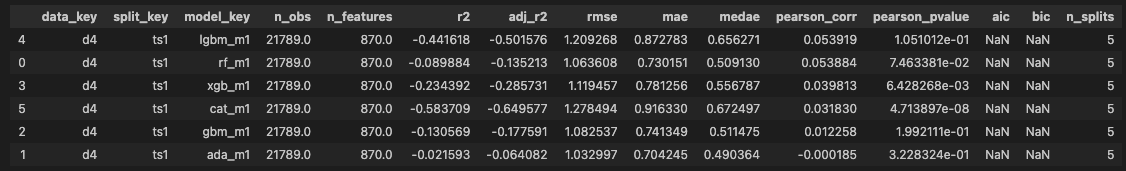

In [7]:
def identify_categorical_with_reason(
    df: pd.DataFrame,
    max_unique: int = 20,
    max_frac: float = 0.05
) -> dict[str, str]:
    """
    Identify columns in df that are likely categorical, and record the reason.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    max_unique : int, default 20
        Absolute threshold for unique values in numeric columns to be considered categorical.
    max_frac : float, default 0.05
        Relative threshold (unique_count / n_rows) for numeric columns to be considered categorical.

    Returns
    -------
    Dict mapping column name -> reason string.
    """
    n_rows = len(df)
    reasons: dict[str, str] = {}

    for col in df.columns:
        series = df[col]
        dtype = series.dtype
        n_unique = series.nunique(dropna=True)

        if pd.api.types.is_object_dtype(dtype):
            reasons[col] = "dtype is object"
            continue

        if pd.api.types.is_categorical_dtype(dtype):
            reasons[col] = "dtype is category"
            continue

        if pd.api.types.is_bool_dtype(dtype):
            reasons[col] = "boolean dtype"
            continue

        if pd.api.types.is_integer_dtype(dtype):
            if n_unique <= max_unique:
                reasons[col] = f"integer dtype with low cardinality (n_unique={n_unique}≤{max_unique})"
                continue
            if (n_unique / n_rows) <= max_frac:
                frac = n_unique / n_rows
                reasons[col] = f"integer dtype with low unique‐to‐row ratio ({n_unique}/{n_rows}={frac:.3f}≤{max_frac})"
                continue

        if pd.api.types.is_float_dtype(dtype):
            if n_unique <= max_unique:
                reasons[col] = f"float dtype with low cardinality (n_unique={n_unique}≤{max_unique})"
                continue
            if (n_unique / n_rows) <= max_frac:
                frac = n_unique / n_rows
                reasons[col] = f"float dtype with low unique‐to‐row ratio ({n_unique}/{n_rows}={frac:.3f}≤{max_frac})"

    return reasons

identify_categorical_with_reason(
    X,
    max_unique=20,
    max_frac=0.05
)

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_21793/718390027.py:34: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


{'X498': 'float dtype with low unique‐to‐row ratio (17069/525887=0.032≤0.05)',
 'X499': 'float dtype with low unique‐to‐row ratio (17931/525887=0.034≤0.05)',
 'X500': 'float dtype with low unique‐to‐row ratio (8066/525887=0.015≤0.05)',
 'X501': 'float dtype with low unique‐to‐row ratio (9685/525887=0.018≤0.05)',
 'X507': 'float dtype with low unique‐to‐row ratio (19976/525887=0.038≤0.05)',
 'X508': 'float dtype with low unique‐to‐row ratio (22015/525887=0.042≤0.05)',
 'X546': 'float dtype with low unique‐to‐row ratio (16729/525887=0.032≤0.05)',
 'X547': 'float dtype with low unique‐to‐row ratio (11254/525887=0.021≤0.05)',
 'X548': 'float dtype with low unique‐to‐row ratio (11080/525887=0.021≤0.05)',
 'X549': 'float dtype with low unique‐to‐row ratio (6239/525887=0.012≤0.05)',
 'X550': 'float dtype with low unique‐to‐row ratio (7227/525887=0.014≤0.05)',
 'X556': 'float dtype with low unique‐to‐row ratio (18098/525887=0.034≤0.05)',
 'X557': 'float dtype with low unique‐to‐row ratio (2109

## 1 Filter

In [8]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

# 1a. Variance Thresholding: remove features with variance < 0.01
# drop any feature whose variance (i.e. its sample variance computed over all rows) is less than 0.1.
variance_thresholds = [0.01, 0.05, 0.1, 0.2]
for threshold in variance_thresholds:
    vt = VarianceThreshold(threshold=threshold)
    X_var = vt.fit_transform(X)  # X is your n×p feature matrix
    # boolean mask of kept columns
    mask = vt.get_support()
    # dropped columns
    dropped_cols = X.columns[~mask]
    print(f"Dropped columns for threshold {threshold}: {list(dropped_cols)}")


Dropped columns for threshold 0.01: ['liqnorm_buysellratio']
Dropped columns for threshold 0.05: ['X184', 'X186', 'X187', 'X190', 'liqnorm_buysellratio']
Dropped columns for threshold 0.1: ['X156', 'X180', 'X183', 'X184', 'X185', 'X186', 'X187', 'X188', 'X190', 'X191', 'X432', 'X435', 'X438', 'liqnorm_buysellratio']
Dropped columns for threshold 0.2: ['X22', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X56', 'X58', 'X70', 'X79', 'X82', 'X84', 'X91', 'X93', 'X94', 'X112', 'X114', 'X119', 'X120', 'X124', 'X136', 'X141', 'X150', 'X156', 'X159', 'X165', 'X166', 'X168', 'X174', 'X180', 'X181', 'X183', 'X184', 'X185', 'X186', 'X187', 'X188', 'X189', 'X190', 'X191', 'X265', 'X267', 'X273', 'X275', 'X277', 'X286', 'X287', 'X288', 'X289', 'X290', 'X291', 'X331', 'X342', 'X373', 'X420', 'X430', 'X431', 'X432', 'X433', 'X434', 'X435', 'X436', 'X437', 'X438', 'X593', 'X644', 'X659', 'X677', 'X724', 'X846', 'X875', 'liqnorm_buysellratio', 'orderflow_imbalance

In [9]:
X[['X184', 'X186', 'X187', 'X190']].describe()

,X184,X186,X187,X190
count,525887.000000,525887.000000,525887.000000,525887.000000
mean,0.080954,0.022828,0.098413,0.110761
std,0.207258,0.205276,0.217390,0.219447
min,-1.765692,-3.522362,-1.765692,-1.814758
25%,-0.023738,-0.055093,-0.019957,-0.016156
50%,0.041331,0.011010,0.058433,0.076171
75%,0.157435,0.085837,0.195853,0.222203
max,2.252727,4.505453,2.252727,2.252727


In [10]:
# 1b. Univariate Selection: select top-20 features by F-test
# skb = SelectKBest(score_func=f_regression, k=20)
# X_uni = skb.fit_transform(X, y)  # y is your target array
# X_uni

top_features = [200, 400, 600, 800]
# top_features = [50, 200]
for k in top_features:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_k = selector.fit_transform(X, y)
    if hasattr(X, "columns"):
        selected_cols = X.columns[selector.get_support()]
        print(f"Top {k} features: {list(selected_cols)}")

Top 200 features: ['X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X50', 'X52', 'X54', 'X71', 'X77', 'X83', 'X89', 'X94', 'X95', 'X105', 'X111', 'X117', 'X121', 'X125', 'X127', 'X131', 'X133', 'X137', 'X139', 'X147', 'X153', 'X159', 'X163', 'X169', 'X173', 'X175', 'X179', 'X181', 'X183', 'X186', 'X189', 'X196', 'X197', 'X198', 'X203', 'X204', 'X205', 'X211', 'X212', 'X217', 'X218', 'X219', 'X224', 'X225', 'X226', 'X238', 'X239', 'X245', 'X246', 'X264', 'X265', 'X266', 'X267', 'X268', 'X269', 'X270', 'X271', 'X272', 'X273', 'X274', 'X275', 'X276', 'X277', 'X278', 'X279', 'X280', 'X281', 'X282', 'X283', 'X284', 'X285', 'X286', 'X287', 'X288', 'X289', 'X290', 'X291', 'X292', 'X293', 'X294', 'X295', 'X296', 'X297', 'X298', 'X299', 'X300', 'X301', 'X302', 'X303', 'X313', 'X319', 'X325', 'X331', 'X336', 'X337', 'X342', 'X349', 'X355', 'X361', 'X367', 'X373', 'X378', 'X379', 'X384

In [11]:
X[X.isna().any(axis=1)]

,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,


## 2 Wrapper

In [12]:
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# # 2a. Recursive Feature Elimination (RFE) with a linear model
# estimator = LinearRegression()
# rfe = RFE(estimator, n_features_to_select=30, step=5)
# X_rfe = rfe.fit_transform(X, y)
# X_rfe

In [13]:
# # 2b. Sequential Forward Selection with a random forest
# sfs = SequentialFeatureSelector(
#     RandomForestRegressor(n_estimators=100, max_depth=5),
#     n_features_to_select=30,
#     direction="forward",
#     scoring="r2",
#     cv=5
# )
# X_sfs = sfs.fit_transform(X, y)
# X_sfs

## 3 Projection Methods

In [14]:
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# component_list = [10, 20, 30, 50, 100]
component_list = [10, ]

pca_values = {}
ica_values = {}

for n in component_list:
    # 4a. PCA: project onto first 10 principal components
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    pca_values[f"PCA_{n}"] = X_pca
    # 4b. ICA: find 10 statistically independent components
    ica = FastICA(n_components=n, max_iter=500)
    X_ica = ica.fit_transform(X)
    ica_values[f"ICA_{n}"] = X_ica

# Parameters

In [15]:
params_data = {
    "d1": {
        "start": pd.Timestamp('2023-03-01 00:00:00'),
        "end": pd.Timestamp('2024-02-29 23:59:00')
    },
    # "d2": {
    #     "start": pd.Timestamp('2023-06-01 00:00:00'),
    #     "end": pd.Timestamp('2024-02-29 23:59:00')
    # },
    # "d3": {
    #     "start": pd.Timestamp('2023-09-01 00:00:00'),
    #     "end":   pd.Timestamp('2024-02-29 23:59:00')
    # },
    "d4": {
        "start": pd.Timestamp('2023-12-01 00:00:00'),
        "end":   pd.Timestamp('2024-02-29 23:59:00')
    }
}

params_split = {
    "ts1": {
        "splitter_func": sklearn_timeseries_split,
        "splitter_args": {"n_splits": 5}
    },
    # "ts2": {
    #     "splitter_func": sklearn_timeseries_split,
    #     "splitter_args": {"n_splits": 10}
    # },
    # "wf1": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 500,
    #         "test_size": 100,
    #         "step_size": 100
    #     }
    # },
    # "wf2": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 1000,
    #         "test_size": 200,
    #         "step_size": 200
    #     }
    # }
}

# Quick-training parameter grid for speed\ n
params_model_tree_fast = {
    "rf_m1": {
        "model_func": model_tree_randomforest,
        "model_args": {"n_estimators": 10, "max_depth": 3, "n_jobs": -1}
    },
    # "ada_m1": {
    #     "model_func": model_tree_adaboost,
    #     "model_args": {"n_estimators": 10, "learning_rate": 1.0}
    # },
    # "gbm_m1": {
    #     "model_func": model_tree_gradient_boosting,
    #     "model_args": {"n_estimators": 10, "learning_rate": 0.3, "max_depth": 3, "subsample": 0.5}
    # },
    # "xgb_m1": {
    #     "model_func": model_tree_xgboost,
    #     "model_args": {"n_estimators": 10, "learning_rate": 0.3, "max_depth": 3, "subsample": 0.5, "tree_method": "hist", "n_jobs": -1}
    # },
    # "lgbm_m1": {
    #     "model_func": model_tree_lightgbm,
    #     "model_args": {"n_estimators": 10, "learning_rate": 0.3, "num_leaves": 31, "n_jobs": -1}
    # },
}

In [16]:
# results = evaluate_grid(
#     X=X, 
#     y=y, 
#     params_data=params_data, 
#     params_split=params_split, 
#     params_model=params_model_tree_fast, 
#     metric_func=evaluate_model,
#     is_linear=False
# )

# Model Training

In [17]:
X_train, X_test, y_train, y_test = sklearn_traintest_split(X, y, test_size=0.3, shuffle=False)
X_train

,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,0.027359,0.035780,0.068219,1.034825,...,0.159183,0.530636,1.814006,3.921505,1.0,0.593620,6.858,131.421,221.389,23.708
2023-03-01 00:01:00,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,...,0.158963,0.530269,16.519692,1.633316,1.0,0.240501,36.254,203.896,847.796,40.926
2023-03-01 00:02:00,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,...,0.158744,0.529901,0.007336,1.167619,1.0,0.077329,-59.808,22.858,295.596,60.692
2023-03-01 00:03:00,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,...,0.158524,0.529534,0.231490,2.686731,1.0,0.457514,-16.151,210.779,460.705,25.881
2023-03-01 00:04:00,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,...,0.158304,0.529167,7.869603,2.216115,1.0,0.378132,23.707,54.004,142.818,30.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 05:25:00,42.613,-0.316648,0.096335,0.177395,0.094867,-0.032564,-0.240218,-0.338348,-0.372513,-0.248211,...,1.469788,2.338208,1.211526,0.184945,1.0,-0.687842,2.705,-29.311,42.613,28.281
2023-11-12 05:26:00,25.050,-0.246827,0.214523,0.306808,0.230663,0.036948,-0.169926,-0.268156,-0.302483,-0.228369,...,1.469946,2.338784,26.653924,1.087326,1.0,0.041836,12.750,1.048,25.050,13.744
2023-11-12 05:27:00,34.009,-0.301947,0.094804,0.190229,0.118450,-0.018021,-0.224422,-0.322827,-0.357354,-0.267332,...,1.470105,2.339359,2.535714,5.058970,1.0,0.669911,5.246,22.783,34.009,12.078


## 1 Fitting simple RF model

In [18]:
rf = model_tree_randomforest(
    X=X_train, 
    y=y_train,
    n_estimators=100, 
    max_depth=5, 
    n_jobs=-1,
    max_features='sqrt'
)

In [19]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

X466           0.021990
X300           0.015538
X465           0.014887
X464           0.014746
X862           0.013186
                 ...   
X514           0.000000
X515           0.000000
X543           0.000000
X545           0.000000
bidask_size    0.000000
Length: 872, dtype: float64

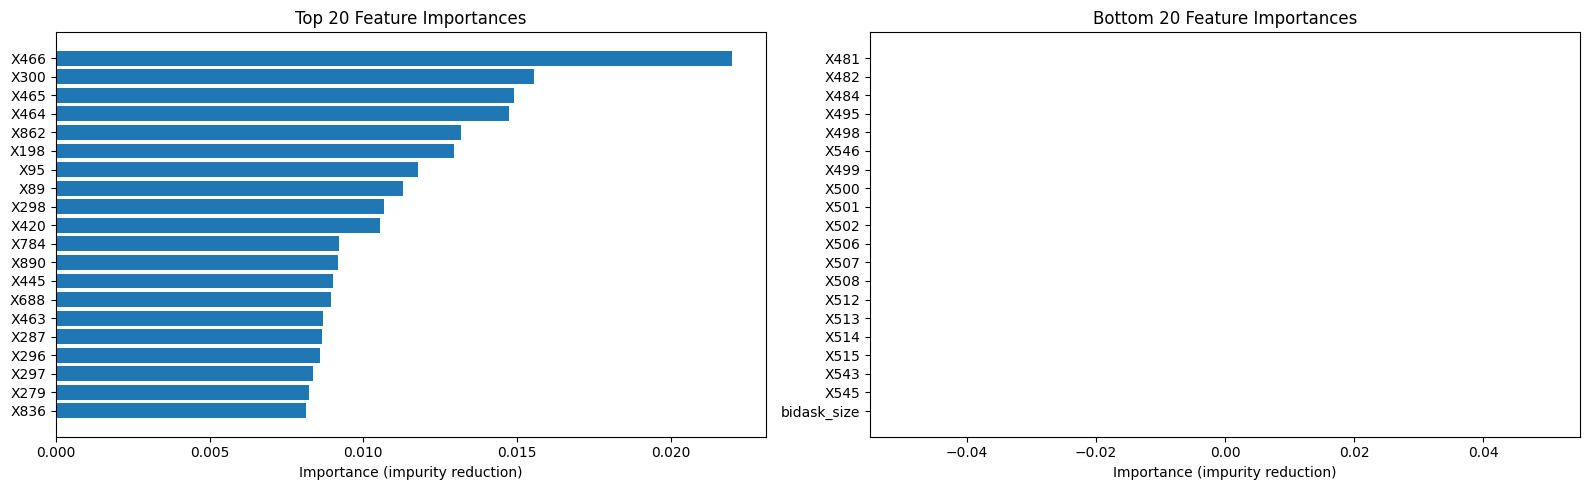

In [ ]:
import matplotlib.pyplot as plt

def plot_treebased_importance(
    model: RandomForestRegressor,
    columns: list[str],
    count: int = 10,
    figsize: tuple[int, int] = (16, 10)
) -> None:
    """
    Plot the top `n_features` and bottom `n_features` feature importances 
    from a fitted RandomForestRegressor.

    Parameters
    ----------
    model : RandomForestRegressor
        A fitted RandomForestRegressor instance.
    columns : list[str]
        List of feature names (must match the order used to fit `model`).
    n_features : int, default 10
        Number of top and bottom features to plot.
    figsize : tuple[int, int], default (16, 10)
        Figure size for the combined 1×2 plot.
    """
    # 1. Build a Series of importances, indexed by feature name, sorted descending
    importances = pd.Series(
        data=model.feature_importances_,
        index=columns
    ).sort_values(ascending=False)

    # 2. Select top-n (highest importance) and bottom-n (lowest importance)
    top_n = importances.head(count)
    bottom_n = importances.tail(count)

    # 3. Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 4. Plot top-n (left); invert y-axis so highest importance appears at top
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} Feature Importances")
    axes[0].set_xlabel("Importance (impurity reduction)")

    # 5. Plot bottom-n (right); invert y-axis so lowest importance appears at top
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} Feature Importances")
    axes[1].set_xlabel("Importance (impurity reduction)")

    plt.tight_layout()
    plt.show()
    return importances

importances = plot_treebased_importance(model=rf, columns=X.columns, count=20, figsize=(16, 5))

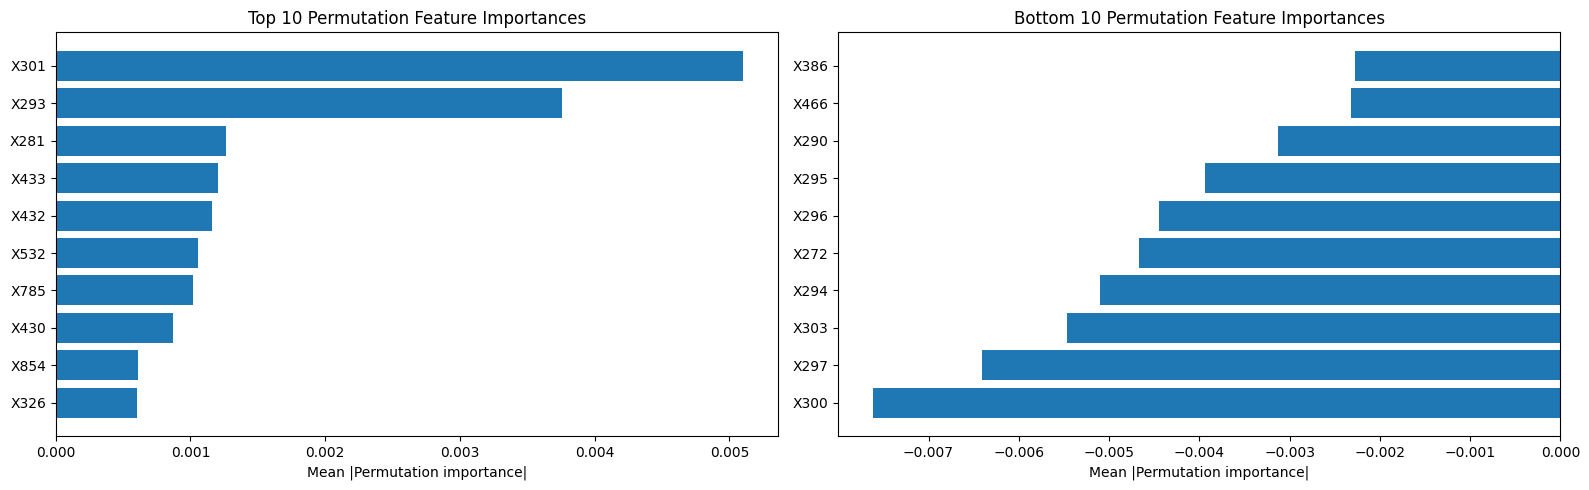

In [ ]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(
    model: RandomForestRegressor,
    X_test: pd.DataFrame,
    y_test: pd.Series | np.ndarray,
    random_state: int | None = None,
    count: int = 10,
    n_repeats: int = 5,
    n_jobs: int = -1,
    scoring: str = 'neg_mean_squared_error',
    figsize: tuple[int, int] = (8, 6)
) -> None:
    """
    Compute permutation importances on a fitted RandomForestRegressor quickly 
    by using parallel jobs and fewer repeats, then plot a descending bar chart of mean importance.

    Parameters
    ----------
    model : RandomForestRegressor
        A fitted RandomForestRegressor instance.
    X_test : pd.DataFrame
        Feature matrix for testing.
    y_test : pd.Series or np.ndarray
        True target values corresponding to X_test.
    random_state : int or None, default=None
        Seed for reproducibility (used by permutation_importance).
    n_repeats : int, default=5
        Number of times to permute a feature. Fewer repeats speeds up computation.
    n_jobs : int, default=-1
        Number of parallel jobs for permutation_importance. Set to -1 to use all available cores.
    scoring : str, default='neg_mean_squared_error'
        Scoring metric to evaluate performance after permutation.
    figsize : tuple[int, int], default=(8, 6)
        Figure size for the bar chart.
    """
    # Optionally subsample X_test if it's very large (uncomment if needed)
    # max_samples = 1000
    # if len(X_test) > max_samples:
    #     X_sub = X_test.sample(n=max_samples, random_state=random_state)
    #     y_sub = y_test[X_sub.index]
    # else:
    #     X_sub, y_sub = X_test, y_test

    # Compute permutation importances using parallel jobs
    perm_res = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=n_jobs
    )

    importances_mean = pd.Series(perm_res.importances_mean, index=X_test.columns).sort_values(ascending=False)

    # 3. Select top‐`count` and bottom‐`count`
    top_n = importances_mean.head(count)
    bottom_n = importances_mean.tail(count)

    # 4. Create a 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 5. Plot top‐count features on the left (highest at top)
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} Permutation Feature Importances")
    axes[0].set_xlabel("Mean |Permutation importance|")

    # 6. Plot bottom‐count features on the right (lowest at top)
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} Permutation Feature Importances")
    axes[1].set_xlabel("Mean |Permutation importance|")

    plt.tight_layout()
    plt.show()
    return importances_mean

permutation = plot_permutation_importance(
    model=rf,
    X_test=X_test,
    y_test=y_test,
    random_state=42,
    count=10,
    n_repeats=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    figsize=(16, 5)
)

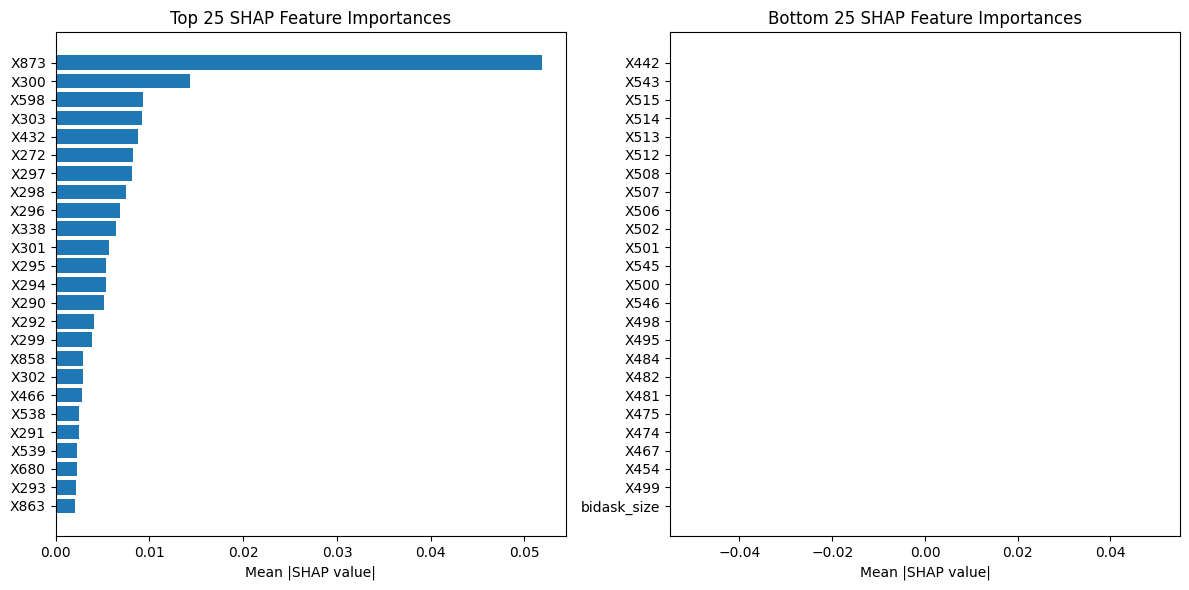

In [ ]:
import shap

def plot_shap_importance(
    X_test: pd.DataFrame,
    model,
    figsize: tuple[int, int] = (12, 6),
    count: int = 10,
) -> None:
    """
    Given a fitted tree‐based model and a test DataFrame X_test, compute TreeSHAP values 
    and plot the top `count` and bottom `count` features by average absolute SHAP value.

    Parameters
    ----------
    X_test : pd.DataFrame
        Test feature matrix (no labels needed for SHAP).
    model : fitted tree‐based estimator
        A fitted model that supports TreeExplainer (e.g., RandomForestRegressor).
    figsize : tuple[int, int], default (12, 6)
        Figure size for the 1×2 plot.
    count : int, default 10
        Number of top and bottom features to display.
    """
    # 1. Compute SHAP values for X_test
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_test)  # shape: (n_test, n_features)

    # 2. Compute mean absolute SHAP value per feature
    mean_abs_shap = pd.Series(
        data=abs(shap_vals).mean(axis=0),
        index=X_test.columns
    ).sort_values(ascending=False)

    # 3. Select top‐`count` and bottom‐`count`
    top_n = mean_abs_shap.head(count)
    bottom_n = mean_abs_shap.tail(count).sort_values(ascending=True)

    # 4. Create a 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 5. Plot top‐count features on the left (highest at top)
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} SHAP Feature Importances")
    axes[0].set_xlabel("Mean |SHAP value|")

    # 6. Plot bottom‐count features on the right (lowest at top)
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} SHAP Feature Importances")
    axes[1].set_xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()

shap_importance = plot_shap_importance(
    X_test=X_test,
    model=rf,
    count=25
)